In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [2]:
class nystrom_trap:
    def __init__(self, n, a, b, lam, x1, x2, rhs):
        
        self.n = n
        self.a = a
        self.b = b
        self.lam = lam
        
        self.t = sp.Symbol('t')
        self.s = sp.Symbol('s')
        self.x1 = x1(self.s)
        self.x2 = x2(self.s)
        self.y1 = x1(self.t)
        self.y2 = x2(self.t)
        
        # initialize h for quadrature
        self.h = (b-a) / n
        
        # initialize arrays
        self.matrix = np.zeros((n,n))
        self.y_values = np.zeros(n)
        self.mu = np.zeros(n)
        
        # initialize everything else
        self.rhs = rhs.subs({q:self.y1,r:self.y2})
        self.jacobian_lam = 0
        self.dgreens_dn_lam = 0
        self.kappa_lam = 0
        
    def get_trap_weights(self,n_in):
        # weights for composite trapezoid rule, which is used to evaluate u
        weights = np.zeros(n_in + 1)
        h_in = (self.b - self.a) / n_in
        weights[0] = 0.5
        weights[n_in] = 0.5
        for i in range(1,n_in):
            weights[i] = 1
        weights = weights * h_in;
        
        return weights

    def get_t_values(self,n_in):
        # values at which a solution will be evaluated at (correspond to composite trapezoid nodes)
        t_values = np.zeros(n_in + 1)
        h_in = (self.b - self.a) / n_in
        for i in range(0,n_in+1):
            t_values[i] = self.a + i*h_in
        
        return t_values
        
    def construct_greens_function(self):
        # build all necessary functions
        # first the Jacobian
        self.jacobian = sp.sqrt(sp.Pow(sp.diff(self.y1,self.t),2) + sp.Pow(sp.diff(self.y2,self.t),2))
        self.jacobian_lam = sp.lambdify(self.t,self.jacobian)

        # normal vector in 2D
        self.normal = (1/self.jacobian) * sp.Array([-1*sp.diff(self.y2,self.t),sp.diff(self.y1,self.t)])

        # greens function and normal derivative
        self.greens_fxn = (1/(2*np.pi)) * sp.log(sp.sqrt(sp.Pow(self.x1 - self.y1,2) + sp.Pow(self.x2 - self.y2,2)))
        self.del_greens_fxn = sp.Array([-1*(1/(2*np.pi))*(1/(sp.Pow(self.x1-self.y1,2) + sp.Pow(self.x2-self.y2,2))) * (self.x1-self.y1),
                                        -1*(1/(2*np.pi))*(1/(sp.Pow(self.x1-self.y1,2) + sp.Pow(self.x2-self.y2,2))) * (self.x2-self.y2)])
        self.dgreens_dn = self.del_greens_fxn[0] * self.normal[0] + self.del_greens_fxn[1] * self.normal[1]
        self.dgreens_dn_simplified = sp.simplify(self.dgreens_dn)
        self.dgreens_dn_lam = sp.lambdify([self.t,self.s],self.dgreens_dn_simplified)
        # order for inputs is (t,s)

        # for the case where the kernel is nearly singular
        self.kappa = (-1/(4*np.pi))*(sp.diff(self.y2,self.t,self.t)*sp.diff(self.y1,self.t)-sp.diff(self.y1,self.t,self.t)*sp.diff(self.y2,self.t))*(1/(sp.Pow(sp.diff(self.y1,self.t),2)+sp.Pow(sp.diff(self.y2,self.t),2)))
        self.kappa_lam = sp.lambdify(self.t,self.kappa)
            
    def build_matrix(self):
        # for loop to build matrix
        for i in range(0,self.n):
            for j in range(0,self.n): 
                if (j != i):
                    self.matrix[i,j] = self.dgreens_dn_lam(self.a + self.h*j, a+self.h*i) * self.jacobian_lam(self.a+self.h*j)
                else:
                    self.matrix[i,j] = self.kappa_lam(self.a+self.h*i)
        # contruct matrix for problem of second kind
        self.matrix = self.lam * np.identity(self.n) + self.h*self.matrix
        
    def solve(self):
        # solve the linear system
        self.y_lam = sp.lambdify(self.t,self.rhs)
        for i in range(0,self.n):
            self.y_values[i] = self.y_lam(self.a + self.h*i)
        
        self.mu = np.linalg.inv(self.matrix)@self.y_values
        return self.mu
    
    def solve_for_u(self,r,theta):
        u = 0
        weights = self.get_trap_weights(self.n)
        t_values = self.get_t_values(self.n)
        print(weights)
        print(t_values)
        #for i in range(0,self.n+1):
        #    u = u + (1/(2*np.pi))*( (r*np.cos(t_values[i] - theta ) - 1) / (1 + r*r - 2*r*np.cos(t_values[i] - theta)) ) * weights[i] * self.mu[i]
            
        #return u
        

In [3]:
q,r = sp.symbols("q r")

# q,r are dummy variables for x1 and x2
rhs = sp.exp(q)*sp.cos(r)
N = 40

a = 0
b = 2*np.pi
lam = -0.5

x1 = sp.cos
x2 = sp.sin

nys = nystrom_trap(N, a, b, lam, x1, x2, rhs)
nys.construct_greens_function()
nys.build_matrix()
mu = nys.solve()

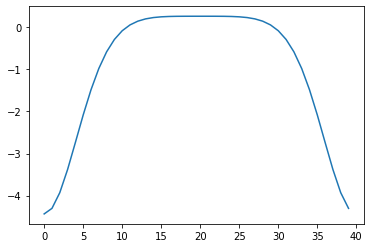

In [4]:
plt.plot(mu)

In [5]:
new_dgreens_dn = nys.dgreens_dn.subs({nys.x1:q, nys.x2: r})
new_dgreens_dn = sp.simplify(new_dgreens_dn)
new_dgreens_dn

0.159154943091895*(q*cos(t) + r*sin(t) - 1)/((q - cos(t))**2 + (r - sin(t))**2)

In [6]:
# solve for u
u = 0
h = nys.h
t = nys.t
lam_dgreens_dn = sp.lambdify(t,new_dgreens_dn)

In [11]:
# N for periodic trapezoid rule, change to N + 1 if not periodic
for i in range(0,N):
        u = u + (h * mu[i] * lam_dgreens_dn(h*i))

In [12]:
u_lam = sp.lambdify([q,r],u)
true_soln = sp.lambdify([q,r],rhs)

In [13]:
print(u_lam(0,0))
print(true_soln(0,0))

0.999999999999997
1.0


In [14]:
b = 30
error = np.zeros(b)
db = 1/30
for i in range(0,b):
    error[i] = np.abs(     u_lam(i*db*1, db*0) - true_soln(i*db*1,db*0)   )

[2.99760217e-15 3.33066907e-15 3.10862447e-15 3.55271368e-15
 3.55271368e-15 3.33066907e-15 3.55271368e-15 3.77475828e-15
 4.21884749e-15 3.99680289e-15 4.21884749e-15 4.21884749e-15
 2.66453526e-15 2.66453526e-14 5.20472554e-13 7.30548955e-12
 8.68534134e-11 8.97006247e-10 8.17636892e-09 6.66393716e-08
 4.91024724e-07 3.30213737e-06 2.04346810e-05 1.17199948e-04
 6.26931822e-04 3.14622976e-03 1.49091268e-02 6.74718744e-02
 3.01616551e-01 1.54217311e+00]


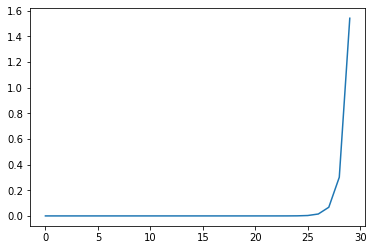

In [15]:
print(error)
plt.plot(error)